In [2]:
'''    Define Node class and its methods    '''
class node:
    def __init__(self, word, word_count=0, parent=None, link=None):
        self.word=word
        self.word_count=word_count
        self.parent=parent
        self.link=link
        self.children={}

    #tree traversal
    def visit_tree(self):

        tree_traversal=[]
        tree_traversal.append(str(vocabdic[self.word]) + " " +str(self.word_count))
        
        # Check if height of tree is >1 , and if it is, then perform traversal by calling the function recursively
        if len(list(self.children.keys()))>0:
            for i in (list(self.children.keys())):
                tree_traversal.append(self.children[i].visit_tree())
        return tree_traversal

In [3]:
'''      Define FPTREE class and its method       '''        
class fptree:
    def __init__(self, data, minsup=400):
        
        #initialize class variables - data and minimum support
        self.data=data
        self.minsup=minsup
        
        #initialise root
        self.root= node(word="Null", word_count=1)
        
        # list of all transactions wherein each transaction contains only frequent itemsets
        # in decreasing order of their count
        self.wordlinesort=[]
        
        # header table containing list of all frequent itemsets , their count and 
        # a linked list for each itemset consisting of all of their occurrences in the FP-Tree
        self.header_table=[]
        
        # dictionary consisting of all frequent itemsets in decreasing order of their  support count
        self.wordsortdic=[]
        
        # dictionary consisting of all itemsets and their support count        
        self.worddic={}
        
        # dictionary consisting of itemsets and their rank 
        # rank is assigned based on support count (decreasing order)
        # i.e rank -> 0 to the itemset with highest count and rank -> N-1 to the itemset with least count
        # where 'N' denotes no. of different items
        self.wordorderdic={}


        # We perform two passes over the database.
        # In the first pass, we construct/fill the dictionaries and lists mentioned above
        # In second pass, we scan each transaction and 
        # build the FP-Tree using the dictionaries and lists defined earlier
        
        
        self.construct(data)
        
    def construct(self, data):
        # scan each transaction in dataset
        for tran in data:
            # scan each word in the transaction
            for words in tran:
                # if the word is seen earlier, increase its count by 1
                # else add that word to dictionary with its 'name' as key and 1 as its value
                if words in self.worddic.keys():
                    self.worddic[words]+=1
                else:
                    self.worddic[words]=1
                    
        # list of all words in the dataset
        wordlist = list(self.worddic.keys())
        
        
        # prune all the words whose support count is less than min. support
        for word in wordlist:
            if(self.worddic[word]<self.minsup):
                del self.worddic[word]
                
        # sort the remaing 1-frequent itemsets in decreasing order of their support count 
        # with first argument as word count and 2nd argument as word name        
        self.wordsortdic = sorted(self.worddic.items(), key=lambda x: (-x[1],x[0])) 
        
        # create a table containing word, wordcount and all link node of that word
        t=0
        for i in self.wordsortdic:
            word = i[0]
            wordc = i[1]
            self.wordorderdic[word]=t
            t+=1
            wordinfo = {'wordn':word, 'wordcc':wordc, 'linknode': None}
            self.header_table.append(wordinfo)
            
            
            
        # construct fptree 
        # go through each transaction in dataset
        for line in data:
            supword=[]
            # go thorugh each word in a particular transaction
            for word in line:
                # only keep words with support count higher than minsupport
                if word in self.worddic.keys():
                    supword.append(word)
                    
           # insert words to the fp tree
        
            # if the transaction contains atleast one frequent word, we need to insert it into the fp-tree
            
            if len(supword)>0:
                # reorder the words based on their rank in the dictionary 'wordorderdic'
                sortsupword = sorted(supword, key = lambda k: self.wordorderdic[k])
                self.wordlinesort.append(sortsupword)
                
                #enter the word one by one from begining
                R = self.root
                
                for i in sortsupword:
                    # if the word is already present in the fp-tree, increase its count by one and 
                    # set the root pointer to its child node
                    if i in R.children.keys():
                        R.children[i].word_count +=1
                        R=R.children[i]
                    
                    # if the word is not present in the fp-tree, create a new node with word_count = 1, parent as 'R'
                    # and link it as child of R.
                    
                    else:

                        R.children[i] = node(word=i,word_count=1,parent=R,link=None)
                        R=R.children[i]
                        
                        # link this node to header_table 
                        
                        # first search for the word in the header table
                        for wordinfo in self.header_table:
                            if wordinfo["wordn"] == R.word:
                                # find the last node of the  node linklist
                                
                                # if the linknode column is NULL, the change it to 'R'
                                if wordinfo["linknode"] is None:
                                    wordinfo["linknode"] = R
                                
                                # if linknode column is not NULL, iterate thorugh the linked-list till 
                                # NULL is encountered and then change it to 'R'
                                else:
                                    iter_node = wordinfo["linknode"]
                                    while(iter_node.link is not None):
                                        iter_node = iter_node.link
                                    iter_node.link = R

# create Conditional Pattern Base for each distinct word in the FP-Tree  
    def condtreetran(self,N):
        if N.parent is None:
            return None
        
        cond_pattern_base =[]
        # start from 'N' and find its all prefix paths 
        while N is not None:
            line=[]
            PN = N.parent
            while PN.parent is not None:
                line.append(PN.word)
                PN=PN.parent
            #reverse order of the nodes encountered while travelling up the tree
            line = line[::-1]
            for i in range(N.word_count):
                cond_pattern_base.append(line)   
            # move on to next linknode in the linked-list from the header-table
            N=N.link
        return cond_pattern_base
    
#Find frequent word list by creating conditional tree
    def get_frequent_items(self,parentnode=None):
        if len(list(self.root.children.keys()))==0:
            return None
        result=[]
        sup=self.minsup
        
        # Bottom-up technique is used (Optimization)
        # starting from the end of header_table say 'word k'
        # (i.e word which has least cupport ocunt among all those that are frequent)
        # we find frequent itemsets involving 'word k' at all levels 
        # using its conditional fp-tree 
        
        # This procedure is done for all items in the header-table except the most frequent one, because
        # its frequent itemsets would have already been taken into account
        revtable = self.header_table[::-1]
        for n in revtable:
            fqset=[set(),0]
            if(parentnode==None):      
                fqset[0]={n['wordn'],}
            else:
                fqset[0] = {n['wordn']}.union(parentnode[0])
            fqset[1]=n['wordcc']
            result.append(fqset)
            condtran = self.condtreetran(n['linknode'])
            #recursively build the conditinal fp tree
            contree= fptree(condtran,sup)
            conwords = contree.get_frequent_items(fqset)
            if conwords is not None:
                for words in conwords:
                    result.append(words)
        return result

#check if tree height is larger than 1 
    def checkheight(self):
        if len(list(self.root.children.keys()))==0:
            return False
        else:
            return True

In [4]:
test_data=[]

In [5]:
def dataFromFile(fname, splitter, front_lim = 0, end_lim = 0):
    """Function which reads from the file and yields a generator"""
    itemSets = []
    #itemSet = set()
    # Open text file
    with open(fname, "r") as file_iter:
        for line in file_iter:
            # Remove trailing commas, spaces, and all other required characters.
            line = line.strip()[front_lim:(-end_lim)]#.rstrip(end_strip).strip() removed it as it removes
            #all eligible characters passed to end_strip argument.
            record = set(line.split(splitter))
            #for item in record:
            #    itemSet.add(frozenset([item]))
            itemSets.append(record)
    return itemSets

In [6]:
data = dataFromFile("BMSWebView2.txt", " -1 ", front_lim = 0, end_lim = 6)

In [7]:
test_data = data

In [74]:
min_sup = 250

In [75]:
fp_tree = fptree(test_data, min_sup)

In [76]:
frequentwordset = fp_tree.get_frequent_items() 

In [77]:
frequentwordset=sorted(frequentwordset,key = lambda k: -k[1] )

In [78]:
len(frequentwordset)

1141

## Using Built-in functions

In [79]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

In [80]:
test_data_dup = test_data

In [81]:
te = TransactionEncoder()
te_ary = te.fit(test_data_dup).transform(test_data_dup)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,195647,197025,198381,198385,198389,198393,198397,198401,198405,198409,...,90085,90101,90109,90117,90125,90133,90141,90149,90157,90161
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77507,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
77508,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
77509,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
77510,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [82]:
from mlxtend.frequent_patterns import fpgrowth

In [83]:
n_transaction = 77512

In [84]:
df1 = fpgrowth(df, min_support=min_sup/n_transaction,use_colnames=True)

In [85]:
df1

,support,itemsets
0,0.004270,(86943)
1,0.003819,(86919)
2,0.007715,(55455)
3,0.016655,(55831)
4,0.012295,(55835)
...,...,...
1136,0.003728,"(55347, 55315)"
1137,0.003741,"(55347, 55267)"
1138,0.004103,"(55347, 55327)"
1139,0.003496,"(55323, 55347, 55319)"


In [86]:
df1.columns

Index(['support', 'itemsets'], dtype='object')

In [21]:
import numpy as np
import timeit
import matplotlib.pyplot as plt

## Comparison

In [44]:
threshold = [400,500,600]

In [45]:
time_builtin=[]
time_my_impl=[]

In [46]:
for i in threshold:
    start=timeit.default_timer()
    #tran_enc= TransactionEncoder()
    #tran_enc_ary = tran_enc.fit(test_data_dup).transform(test_data_dup)
    #df_= pd.DataFrame(tran_enc_ary, columns=tran_enc.columns_)
    df_final = fpgrowth(df, min_support=i/n_transaction,use_colnames=True)
    
    stop = timeit.default_timer()
    time_builtin.append(stop-start)    

In [47]:
time_builtin

[2.87755169999582, 2.1433714000013424, 2.0146661000035238]

In [48]:
for i in threshold:
    begin = timeit.default_timer()
    
    fp_tree_temp = fptree(test_data,i)
    frequentwordset_temp = fp_tree_temp.get_frequent_items() 
    
    end = timeit.default_timer()
    
    time_my_impl.append(end-begin)

In [49]:
time_my_impl

[7.1343777000001865, 5.239440299999842, 4.317271500003699]

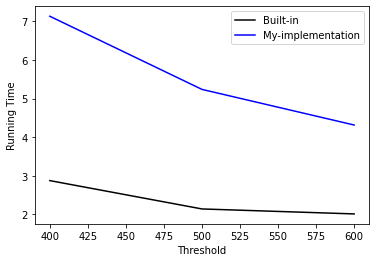

In [50]:
plt.plot(threshold,time_builtin,label="Built-in",color='black')
plt.plot(threshold,time_my_impl,label="My-implementation",color='blue')
plt.legend(loc='best')
plt.xlabel("Threshold")
plt.ylabel("Running Time");

## Find Closed Frequent itemsets

**Using the frequent itemsets generated by FP-Tree method, we find closed frequent itemsets**

In [87]:
supp_unique = df1.support.unique()
#all unique support count

In [88]:
#Dictionary storing itemset with same support count as key
freq_dic = {}
for i in range(len(supp_unique)):
    inset = list(df1.loc[df1.support ==supp_unique[i]]['itemsets'])
    freq_dic[supp_unique[i]] = inset

In [89]:
#Find closed frequent itemsets
closed_freq = []
for idx,data in df1.iterrows():
    cl_sup = data['support']
    cl_item = data['itemsets']
    flag = True
    iter_list = freq_dic[cl_sup]
    
    for i in iter_list:
        if(cl_item!=i):
            if(set(cl_item).issubset(set(i))):
                flag = False
                break
    if(flag):
        closed_freq.append(cl_item)  

In [90]:
print("No. of closed frequent itemsets is ",len(closed_freq))

No. of closed frequent itemsets is  1141


In [91]:
for i in range(len(closed_freq)):
    print(closed_freq[i])

frozenset({'86943'})
frozenset({'86919'})
frozenset({'55455'})
frozenset({'55831'})
frozenset({'55835'})
frozenset({'56765'})
frozenset({'55839'})
frozenset({'55863'})
frozenset({'55407'})
frozenset({'55435'})
frozenset({'55411'})
frozenset({'55403'})
frozenset({'55879'})
frozenset({'55895'})
frozenset({'55991'})
frozenset({'55323'})
frozenset({'55327'})
frozenset({'55295'})
frozenset({'55287'})
frozenset({'55331'})
frozenset({'82875'})
frozenset({'89849'})
frozenset({'89845'})
frozenset({'86979'})
frozenset({'89829'})
frozenset({'78163'})
frozenset({'84827'})
frozenset({'55283'})
frozenset({'89453'})
frozenset({'84731'})
frozenset({'55779'})
frozenset({'228795'})
frozenset({'88683'})
frozenset({'55343'})
frozenset({'55859'})
frozenset({'81699'})
frozenset({'89705'})
frozenset({'89701'})
frozenset({'55803'})
frozenset({'55319'})
frozenset({'55367'})
frozenset({'82719'})
frozenset({'55267'})
frozenset({'55271'})
frozenset({'55351'})
frozenset({'55315'})
frozenset({'56761'})
frozenset({'